# Simplified AmoebaNet

This project uses genetic algorithms to the [Simplified NASNet](NASNet.ipynb) search space. We demonstrate the search capabilities on the CIFAR-10 classification dataset. The search space and the target network architecture are identical to the Simplified NASNet. Please refer it to learn more about the search space design.

Algorithm:
1. We initialize a population of 20 child networks. The are trained for 7 epochs and their performance is benchmarked on the validation set. The population is implemented as a queue of fixed size (20). If it overflows, the older networks are dropped.
2. We sample 8 child networks from the population, choose the best (highest validation accuracy) network from the sample and apply 2 mutations. The mutated child is benchmarked and added to the population.
3. The previous step (step 2) is repeated for 80 episodes or cycles.
4. The initial population and subsequent child networks are all stored in a history buffer. After all the cycles are finished, we pick the best model in the history to design the normal and reduction cells for the target network.

* Best Accuracy: 78.06%
* Best Configuration:

<pre>
[[[1 1 2 2 1]
  [1 0 5 3 0]
  [0 1 2 4 1]
  [1 1 4 1 0]
  [0 0 5 1 0]]

 [[1 0 2 2 1]
  [1 0 2 3 0]
  [0 1 1 0 1]
  [0 1 4 4 0]
  [0 0 2 0 1]]]
</pre>
<img src='amoeba.v1.best.cells.png'/>



## Import Modules used in this Notebook

In [1]:
%%capture

import random

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Dataset Setup

In [2]:
# DATASET = 'mnist'
DATASET = 'cifar10'

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

2022-11-08 08:33:35.560142: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

2022-11-08 08:33:42.972829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:33:43.068525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:33:43.069549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:33:43.072787: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


2022-11-08 08:34:42.018952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-08 08:34:42.072253: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


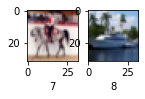

In [3]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

## Architecture Search

In [4]:
CHILD_PARAMS = dict(
    epochs=7,
    batch_size=128,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]

TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size'])
VDS = CHILD_PARAMS['val_ds'].batch(256)

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        """
        It transforms the input branches to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        """
        It halves the input feature space using a convolution layer with stride 2
        """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        """
        It constructs a cell based on the cell_config and the branches.
        A cell_config is 2-D numpy array of shape [5,5] which contains
        the 5 state choices for each of the 5 blocks.
        """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class Child(object):
    def __init__(self, config, train=True):
        self.config = config
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(self.config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=CHILD_PARAMS['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy


CONTROLLER_PARAMS = dict(
    episodes=80,
    population_size=20,
    sample_size=8,
    mutation_size=2
)

BLOCK_TIMESTEPS = 5
CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self):
        self.population_size = CONTROLLER_PARAMS['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = CONTROLLER_PARAMS['sample_size']
        self.best_accuracies = []
    
    def random_state(self, address):
        (_, __, state_id) = address
        return randrange(len(STATE_SPACE[state_id]['values']))

    def create_random_child(self):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)
        child = Child(config)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.population_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)

        def mutate_once():
            mutation_address = tuple(map(randrange, TIMESTEP_ADDRESS_SPACE))
            state_id = mutation_address[-1]
            state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
            mutation = randrange(len(STATE_SPACE[state_space_id]['values']))

            return mutation_address, mutation

        def apply_mutation(config):
            address, mutation = mutate_once()
            print(address, mutation)
            config[address] = mutation
            return config
    
        mutated_config = reduce(
            lambda x,_: apply_mutation(x),
            range(2),
            config.copy())

        return mutated_config
    
    def run_cycle(self):
        # Pick random children from the population for the mutation stage
        p_sample = sample(range(len(self.population)), self.sample_size)

        # Find the best child in the sample
        accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        best_sample = np.argmax(accuracies)
        print('Best Child: {:2d} Accuracy: {:4f}'.format(
            p_sample[best_sample],
            accuracies[best_sample]
        ))

        # Record the best accuracies
        self.best_accuracies.append(accuracies[best_sample])

        # Mutate the best child
        best_child = self.population[p_sample[best_sample]]
        mutated_child = Child(self.mutate(best_child.config))

        # Update population
        print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
            self.population[0].config,
            self.population[0].accuracy
        ))
        print('Mutation Candidate: {}\n Accuracy: {:1.5f}'.format(
            best_child.config,
            best_child.accuracy
        ))
        self.population.append(mutated_child)
                
        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller()
controller.initialize_population()

for episode in range(CONTROLLER_PARAMS['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()

Epoch 1/7


2022-11-08 08:34:46.183046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  3/313 [..............................] - ETA: 31s - loss: 7.5437 - accuracy: 0.1198

  5/313 [..............................] - ETA: 29s - loss: 6.9537 - accuracy: 0.1016

  8/313 [..............................] - ETA: 26s - loss: 6.2828 - accuracy: 0.0986

 11/313 [>.............................] - ETA: 24s - loss: 5.8657 - accuracy: 0.0987

 13/313 [>.............................] - ETA: 24s - loss: 5.5151 - accuracy: 0.1088

 16/313 [>.............................] - ETA: 23s - loss: 5.0662 - accuracy: 0.1079

 20/313 [>.............................] - ETA: 22s - loss: 4.5589 - accuracy: 0.1195

 22/313 [=>............................] - ETA: 22s - loss: 4.3605 - accuracy: 0.1186

 25/313 [=>............................] - ETA: 21s - loss: 4.1123 - accuracy: 0.1206

 28/313 [=>............................] - ETA: 21s - loss: 3.9112 - accuracy: 0.1233

 30/313 [=>............................] - ETA: 21s - loss: 3.7951 - accuracy: 0.1326

 33/313 [==>...........................] - ETA: 21s - loss: 3.6430 - accuracy: 0.1420

 36/313 [==>...........................] - ETA: 20s - loss: 3.5137 - accuracy: 0.1517

 39/313 [==>...........................] - ETA: 20s - loss: 3.4025 - accuracy: 0.1579

 42/313 [===>..........................] - ETA: 20s - loss: 3.2991 - accuracy: 0.1680

 44/313 [===>..........................] - ETA: 20s - loss: 3.2439 - accuracy: 0.1692

 48/313 [===>..........................] - ETA: 19s - loss: 3.1402 - accuracy: 0.1756

 50/313 [===>..........................] - ETA: 19s - loss: 3.0918 - accuracy: 0.1795

 53/313 [====>.........................] - ETA: 19s - loss: 3.0348 - accuracy: 0.1832

 56/313 [====>.........................] - ETA: 19s - loss: 2.9768 - accuracy: 0.1885

 59/313 [====>.........................] - ETA: 18s - loss: 2.9273 - accuracy: 0.1925

 62/313 [====>.........................] - ETA: 18s - loss: 2.8814 - accuracy: 0.1978

 64/313 [=====>........................] - ETA: 18s - loss: 2.8558 - accuracy: 0.1997

 68/313 [=====>........................] - ETA: 18s - loss: 2.8035 - accuracy: 0.2042

 70/313 [=====>........................] - ETA: 18s - loss: 2.7798 - accuracy: 0.2055

 73/313 [=====>........................] - ETA: 17s - loss: 2.7442 - accuracy: 0.2100

 76/313 [======>.......................] - ETA: 17s - loss: 2.7144 - accuracy: 0.2126

 79/313 [======>.......................] - ETA: 17s - loss: 2.6882 - accuracy: 0.2146

 82/313 [======>.......................] - ETA: 16s - loss: 2.6628 - accuracy: 0.2163

 85/313 [=======>......................] - ETA: 16s - loss: 2.6390 - accuracy: 0.2176

 87/313 [=======>......................] - ETA: 16s - loss: 2.6238 - accuracy: 0.2184

 90/313 [=======>......................] - ETA: 16s - loss: 2.6017 - accuracy: 0.2196

 92/313 [=======>......................] - ETA: 16s - loss: 2.5891 - accuracy: 0.2199

 95/313 [========>.....................] - ETA: 16s - loss: 2.5680 - accuracy: 0.2219

 98/313 [========>.....................] - ETA: 16s - loss: 2.5459 - accuracy: 0.2243

100/313 [========>.....................] - ETA: 16s - loss: 2.5336 - accuracy: 0.2260

103/313 [========>.....................] - ETA: 15s - loss: 2.5155 - accuracy: 0.2269

107/313 [=========>....................] - ETA: 15s - loss: 2.4922 - accuracy: 0.2293

109/313 [=========>....................] - ETA: 15s - loss: 2.4807 - accuracy: 0.2319

112/313 [=========>....................] - ETA: 15s - loss: 2.4631 - accuracy: 0.2347

115/313 [==========>...................] - ETA: 14s - loss: 2.4502 - accuracy: 0.2357

118/313 [==========>...................] - ETA: 14s - loss: 2.4372 - accuracy: 0.2369

121/313 [==========>...................] - ETA: 14s - loss: 2.4250 - accuracy: 0.2377

124/313 [==========>...................] - ETA: 14s - loss: 2.4148 - accuracy: 0.2385

126/313 [===========>..................] - ETA: 13s - loss: 2.4076 - accuracy: 0.2387

129/313 [===========>..................] - ETA: 13s - loss: 2.3966 - accuracy: 0.2391

132/313 [===========>..................] - ETA: 13s - loss: 2.3831 - accuracy: 0.2407

135/313 [===========>..................] - ETA: 13s - loss: 2.3723 - accuracy: 0.2418

138/313 [============>.................] - ETA: 13s - loss: 2.3612 - accuracy: 0.2431

140/313 [============>.................] - ETA: 12s - loss: 2.3537 - accuracy: 0.2442

143/313 [============>.................] - ETA: 12s - loss: 2.3433 - accuracy: 0.2461

146/313 [============>.................] - ETA: 12s - loss: 2.3347 - accuracy: 0.2469

149/313 [=============>................] - ETA: 12s - loss: 2.3253 - accuracy: 0.2487

152/313 [=============>................] - ETA: 12s - loss: 2.3177 - accuracy: 0.2494

155/313 [=============>................] - ETA: 11s - loss: 2.3084 - accuracy: 0.2506

158/313 [==============>...............] - ETA: 11s - loss: 2.3005 - accuracy: 0.2512

160/313 [==============>...............] - ETA: 11s - loss: 2.2960 - accuracy: 0.2515

163/313 [==============>...............] - ETA: 11s - loss: 2.2896 - accuracy: 0.2518

167/313 [===============>..............] - ETA: 10s - loss: 2.2817 - accuracy: 0.2521

169/313 [===============>..............] - ETA: 10s - loss: 2.2769 - accuracy: 0.2522

172/313 [===============>..............] - ETA: 10s - loss: 2.2703 - accuracy: 0.2529

175/313 [===============>..............] - ETA: 10s - loss: 2.2629 - accuracy: 0.2543

178/313 [================>.............] - ETA: 10s - loss: 2.2548 - accuracy: 0.2551

181/313 [================>.............] - ETA: 9s - loss: 2.2468 - accuracy: 0.2563

184/313 [================>.............] - ETA: 9s - loss: 2.2401 - accuracy: 0.2571

187/313 [================>.............] - ETA: 9s - loss: 2.2343 - accuracy: 0.2578

190/313 [=================>............] - ETA: 9s - loss: 2.2272 - accuracy: 0.2587

193/313 [=================>............] - ETA: 8s - loss: 2.2206 - accuracy: 0.2590

195/313 [=================>............] - ETA: 8s - loss: 2.2168 - accuracy: 0.2593

198/313 [=================>............] - ETA: 8s - loss: 2.2106 - accuracy: 0.2604

201/313 [==================>...........] - ETA: 8s - loss: 2.2052 - accuracy: 0.2615

204/313 [==================>...........] - ETA: 8s - loss: 2.1998 - accuracy: 0.2627

207/313 [==================>...........] - ETA: 7s - loss: 2.1936 - accuracy: 0.2640

210/313 [===================>..........] - ETA: 7s - loss: 2.1887 - accuracy: 0.2643

212/313 [===================>..........] - ETA: 7s - loss: 2.1853 - accuracy: 0.2647

215/313 [===================>..........] - ETA: 7s - loss: 2.1791 - accuracy: 0.2658

218/313 [===================>..........] - ETA: 7s - loss: 2.1726 - accuracy: 0.2674

221/313 [====================>.........] - ETA: 6s - loss: 2.1665 - accuracy: 0.2687

224/313 [====================>.........] - ETA: 6s - loss: 2.1608 - accuracy: 0.2692

226/313 [====================>.........] - ETA: 6s - loss: 2.1569 - accuracy: 0.2698

229/313 [====================>.........] - ETA: 6s - loss: 2.1519 - accuracy: 0.2708

231/313 [=====================>........] - ETA: 6s - loss: 2.1479 - accuracy: 0.2717

234/313 [=====================>........] - ETA: 5s - loss: 2.1430 - accuracy: 0.2726

236/313 [=====================>........] - ETA: 5s - loss: 2.1393 - accuracy: 0.2734

239/313 [=====================>........] - ETA: 5s - loss: 2.1329 - accuracy: 0.2750

242/313 [======================>.......] - ETA: 5s - loss: 2.1275 - accuracy: 0.2758

245/313 [======================>.......] - ETA: 5s - loss: 2.1220 - accuracy: 0.2771

248/313 [======================>.......] - ETA: 4s - loss: 2.1173 - accuracy: 0.2780

251/313 [=======================>......] - ETA: 4s - loss: 2.1128 - accuracy: 0.2790

254/313 [=======================>......] - ETA: 4s - loss: 2.1081 - accuracy: 0.2802

256/313 [=======================>......] - ETA: 4s - loss: 2.1051 - accuracy: 0.2808

259/313 [=======================>......] - ETA: 4s - loss: 2.1005 - accuracy: 0.2822

262/313 [========================>.....] - ETA: 3s - loss: 2.0972 - accuracy: 0.2825

265/313 [========================>.....] - ETA: 3s - loss: 2.0929 - accuracy: 0.2832

267/313 [========================>.....] - ETA: 3s - loss: 2.0904 - accuracy: 0.2836

270/313 [========================>.....] - ETA: 3s - loss: 2.0861 - accuracy: 0.2843

273/313 [=========================>....] - ETA: 2s - loss: 2.0823 - accuracy: 0.2848

276/313 [=========================>....] - ETA: 2s - loss: 2.0781 - accuracy: 0.2856

278/313 [=========================>....] - ETA: 2s - loss: 2.0747 - accuracy: 0.2868

281/313 [=========================>....] - ETA: 2s - loss: 2.0710 - accuracy: 0.2875

284/313 [==========================>...] - ETA: 2s - loss: 2.0663 - accuracy: 0.2889

287/313 [==========================>...] - ETA: 1s - loss: 2.0618 - accuracy: 0.2900

291/313 [==========================>...] - ETA: 1s - loss: 2.0566 - accuracy: 0.2906

293/313 [===========================>..] - ETA: 1s - loss: 2.0541 - accuracy: 0.2914

296/313 [===========================>..] - ETA: 1s - loss: 2.0511 - accuracy: 0.2918

298/313 [===========================>..] - ETA: 1s - loss: 2.0484 - accuracy: 0.2923

301/313 [===========================>..] - ETA: 0s - loss: 2.0444 - accuracy: 0.2932

304/313 [============================>.] - ETA: 0s - loss: 2.0408 - accuracy: 0.2940

307/313 [============================>.] - ETA: 0s - loss: 2.0379 - accuracy: 0.2948

313/313 [==============================] - ETA: 0s - loss: 2.0312 - accuracy: 0.2963

313/313 [==============================] - 47s 120ms/step - loss: 2.0312 - accuracy: 0.2963 - val_loss: 1.6268 - val_accuracy: 0.4083


Epoch 2/7
313/313 [==============================] - 25s 81ms/step - loss: 1.5903 - accuracy: 0.4216 - val_loss: 1.4550 - val_accuracy: 0.4774
Epoch 3/7
313/313 [==============================] - 25s 81ms/step - loss: 1.4137 - accuracy: 0.4938 - val_loss: 1.3321 - val_accuracy: 0.5225
Epoch 4/7
313/313 [==============================] - 25s 81ms/step - loss: 1.2979 - accuracy: 0.5408 - val_loss: 1.3237 - val_accuracy: 0.5296
Epoch 5/7
313/313 [==============================] - 26s 82ms/step - loss: 1.1965 - accuracy: 0.5801 - val_loss: 1.1109 - val_accuracy: 0.6120
Epoch 6/7
313/313 [==============================] - 25s 81ms/step - loss: 1.1095 - accuracy: 0.6125 - val_loss: 1.0444 - val_accuracy: 0.6419
Epoch 7/7
313/313 [==============================] - 26s 82ms/step - loss: 1.0455 - accuracy: 0.6377 - val_loss: 0.9941 - val_accuracy: 0.6557
Child: [[[0 0 5 3 0]
  [0 1 3 3 1]
  [1 0 5 5 1]
  [1 0 2 5 0]
  [1 1 0 3 0]]

 [[1 0 2 3 0]
  [1 0 4 0 0]
  [1 1 5 3 1]
  [1 0 5 5 0]
  [0 0 

## Training Metrics

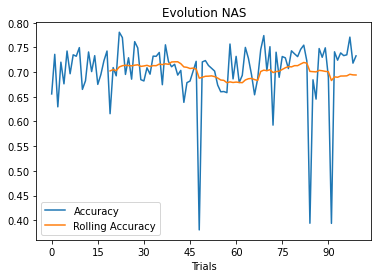

In [5]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

## Performance Analysis

[0.7494750022888184,
 0.7494750022888184,
 0.7494750022888184,
 0.7494750022888184,
 0.7806000113487244,
 0.7494750022888184,
 0.7806000113487244,
 0.7806000113487244,
 0.7698000073432922,
 0.7698000073432922,
 0.7698000073432922,
 0.7406499981880188,
 0.7488499879837036,
 0.7425500154495239,
 0.7806000113487244,
 0.7806000113487244,
 0.7806000113487244,
 0.7698000073432922,
 0.7551500201225281,
 0.7806000113487244,
 0.7806000113487244,
 0.7616000175476074,
 0.7396500110626221,
 0.7698000073432922,
 0.7616000175476074,
 0.7616000175476074,
 0.7616000175476074,
 0.7396500110626221,
 0.7551500201225281,
 0.7551500201225281,
 0.7551500201225281,
 0.7396500110626221,
 0.7551500201225281,
 0.7322250008583069,
 0.7551500201225281,
 0.7232499718666077,
 0.7551500201225281,
 0.7551500201225281,
 0.7232499718666077,
 0.7232499718666077,
 0.756725013256073,
 0.7317249774932861,
 0.7232499718666077,
 0.7204999923706055,
 0.7132999897003174,
 0.749875009059906,
 0.7317249774932861,
 0.756725013256

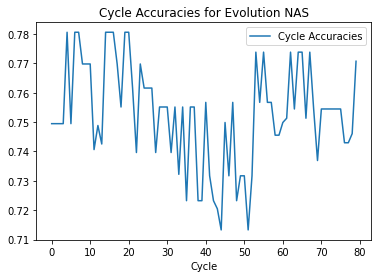

In [6]:
plt.plot(controller.best_accuracies, label='Cycle Accuracies')
plt.xlabel('Cycle')
plt.legend()
plt.title('Cycle Accuracies for Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

controller.best_accuracies